<a href="https://colab.research.google.com/github/alanjeffares/Simplex/blob/main/notebooks/rank_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alanjeffares/Simplex.git

Cloning into 'Simplex'...
remote: Enumerating objects: 625, done.
remote: Counting objects: 100% (625/625), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 625 (delta 365), reused 395 (delta 153), pack-reused 0
Receiving objects: 100% (625/625), 1.35 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (365/365), done.


In [24]:
!pip install captum
!pip install pytorch_influence_functions


# science plots requirements
!apt-get update
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install SciencePlots
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.4 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [872 kB]
Get:13 http

In [3]:
%cd Simplex/
import explainers
from explainers.simplex import Simplex
import models
from models.image_recognition import MnistClassifier
from utils.schedulers import ExponentialScheduler
from experiments.mnist import load_mnist
%cd ../

/content/Simplex
/content


In [5]:
# hyperparams
corpus_size = 100
cv_ls = list(range(10))

In [6]:
# run the code
%cd Simplex/
for cv in cv_ls:
  !python -m experiments.mnist -experiment "approximation_quality" -cv $cv -corpus_size $corpus_size
%cd ../

/content/Simplex
----------------------------------------------------------------------------------------------------
Welcome in the approximation quality experiment for MNIST. 
Settings: random_seed = 42 ; cv = 0.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Now fitting the model. 
----------------------------------------------------------------------------------------------------
9913344it [00:00, 23075971.88it/s]                 
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

29696it [00:00, 86495869.16it/s]
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

1649664it [00:00, 7459579.15it/s]                 
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

5120it [00:00, 26381863.00it/s]
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data

In [74]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(dists: torch.tensor, selected_idx: torch.tensor):
  label_size = 35
  tick_size = 25

  plt.figure(figsize=(15,5))
  plt.ylabel('Distance to test example', fontsize=tick_size)
  plt.xticks(fontsize = tick_size)
  plt.yticks(fontsize = tick_size)
  plt.xlabel('Corpus examples', fontsize=tick_size)
  
  vals, _ = torch.sort(dists)
  barlist = plt.bar(list(range(0,100)), vals.squeeze(0).cpu().numpy(), width=1,
                    facecolor = '#4575b4', edgecolor='lightgrey', linewidth=0.2)
  for idx in selected_idx:
    barlist[idx.item()].set_color('#d73027')
    barlist[idx.item()].set_edgecolor('lightgrey')
  plt.savefig('hist2.pdf', format='pdf', dpi=1200)
  plt.show()

def load_run(cv: int):
  simplex = pickle.load( open( f"/content/Simplex/experiments/results/mnist/quality/simplex_cv{cv}_n5.pkl", "rb" ) )

  # load saved model
  classifier = MnistClassifier()
  classifier.load_state_dict(torch.load(f'/content/Simplex/experiments/results/mnist/quality/model_cv{cv}.pth'))
  classifier.to('cuda')
  classifier.eval()
  return simplex, classifier

simplex, classifier = load_run(0)

In [49]:
# for test example i which examples in the corpus have weight > 0.01
i = 0
test_i_lrg_corpus_weights = simplex.weights[i] > 0.01

In [50]:
# find the latent state of the test example
test_example = simplex.test_examples[i].unsqueeze(0)
test_example_latent_true = classifier.latent_representation(test_example)

# this is equivelent and returns the same vector
test_example_latent_true = simplex.test_latent_reps[i].unsqueeze(0)

# now grab the approximation of that vector in the corpus convex hull
test_latent_approx = simplex.latent_approx()
test_example_latent_approx = test_latent_approx[i].unsqueeze(0)

# distance between true latent and approx latent of test example
approx_dist = torch.sum((test_example_latent_approx - test_example_latent_true)**2)**0.5
print('Distance between latent approx and latent true:', approx_dist.item())

Distance between latent approx and latent true: 5.254690170288086


Latent test representation distance to each corpus representation is calcuated and ordered (low to high).
Then the rank of the corpus examples used in the reconstruction is extracted.

Approximate latent representation of the test example: tensor([ 1,  2, 68], device='cuda:0')
With corresponding weight values:  tensor([0.3299, 0.4351, 0.2263], device='cuda:0')


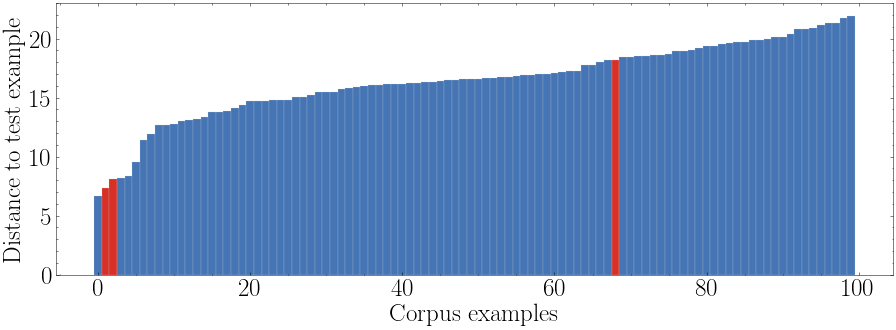


True latent representation of the test example: tensor([ 1,  2, 55], device='cuda:0')
With corresponding weight values:  tensor([0.3299, 0.4351, 0.2263], device='cuda:0')


In [75]:
# calculate distance from test latent approximation to the highly weighted corpus examples
dists = torch.cdist(test_example_latent_approx, simplex.corpus_latent_reps)
_, ranks = torch.unique(dists, sorted=True, return_inverse=True)
sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()


print('Latent test representation distance to each corpus representation is calcuated and ordered (low to high).')
print('Then the rank of the corpus examples used in the reconstruction is extracted.\n')
print('Approximate latent representation of the test example:', sorted_ranks)
vals, idxs = torch.sort(dists)
weights = simplex.weights[i][idxs[0]][test_i_lrg_corpus_weights[idxs[0]]]
print('With corresponding weight values: ', weights)
plot_bar(dists, ranks[0,test_i_lrg_corpus_weights])


# calculate distance from test latent ground truth to the highly weighted corpus examples
dists = torch.cdist(test_example_latent_true, simplex.corpus_latent_reps)
_, ranks = torch.unique(dists, sorted=True, return_inverse=True)
sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()

print('\nTrue latent representation of the test example:', sorted_ranks)
vals, idxs = torch.sort(dists)
weights = simplex.weights[i][idxs[0]][test_i_lrg_corpus_weights[idxs[0]]]
print('With corresponding weight values: ', weights)

# plot_bar(dists, ranks[0,test_i_lrg_corpus_weights])


In [11]:

def reconstruction_rank_dist(i, simplex):
  """
  Of the latent corpus examples used to approximate the test example with
  weight > 0.01, find and return their rank distance to the original latent test
  example of the 1000 total corpus examples and also return their associated 
  weights.
  """
  test_i_lrg_corpus_weights = simplex.weights[i] > 0.01

  # this is equivelent and returns the same vector
  test_example_latent_true = simplex.test_latent_reps[i].unsqueeze(0)

  # now grab the approximation of that vector in the corpus convex hull
  test_latent_approx = simplex.latent_approx()
  test_example_latent_approx = test_latent_approx[i].unsqueeze(0)

  # calculate distance from test latent approximation to the highly weighted corpus examples
  dists = torch.cdist(test_example_latent_approx, simplex.corpus_latent_reps)
  _, ranks = torch.unique(dists, sorted=True, return_inverse=True)
  sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()

  # calculate distance from test latent ground truth to the highly weighted corpus examples
  dists = torch.cdist(test_example_latent_true, simplex.corpus_latent_reps)
  _, ranks = torch.unique(dists, sorted=True, return_inverse=True)
  sorted_ranks, _ = ranks[0,test_i_lrg_corpus_weights].sort()

  vals, idxs = torch.sort(dists)
  weights = simplex.weights[i][idxs[0]][test_i_lrg_corpus_weights[idxs[0]]]
  return sorted_ranks, weights

def calculate_for_test(simplex):
  N_TEST = 100
  weighted_ranks = torch.empty(0, device='cuda')
  all_ranks = torch.empty(0, device='cuda')
  for i in range(N_TEST):
    sorted_ranks, weights = reconstruction_rank_dist(i, simplex)
    all_ranks = torch.cat([all_ranks, sorted_ranks])
    weighted_rank_i = sorted_ranks * weights
    weighted_ranks = torch.cat([weighted_ranks,weighted_rank_i])
  return weighted_ranks, all_ranks

In [12]:
n_test = 100
avg_weighted_ranks = []
avg_avg_ranks = []
all_ranks_full = []
for cv in cv_ls:
  simplex, classifier = load_run(cv)
  weighted_ranks, all_ranks = calculate_for_test(simplex)
  weighted_rank = weighted_ranks.sum()/n_test
  avg_rank = torch.mean(all_ranks)
  print('Weighted rank:', weighted_rank.item())
  print('Raw average rank: ', avg_rank.item())
  avg_weighted_ranks.append(weighted_rank.item())
  avg_avg_ranks.append(avg_rank.item())
  all_ranks_full.extend(all_ranks.cpu().tolist())
  


Weighted rank: 4.6459269523620605
Raw average rank:  9.16464900970459
Weighted rank: 4.556447505950928
Raw average rank:  8.503649711608887
Weighted rank: 4.700008392333984
Raw average rank:  8.49400520324707
Weighted rank: 4.27772855758667
Raw average rank:  6.944711685180664
Weighted rank: 4.627486705780029
Raw average rank:  7.525179862976074
Weighted rank: 4.2587409019470215
Raw average rank:  7.700460910797119
Weighted rank: 4.835953235626221
Raw average rank:  8.122352600097656
Weighted rank: 4.5679521560668945
Raw average rank:  9.148882865905762
Weighted rank: 4.485421180725098
Raw average rank:  8.66416072845459
Weighted rank: 3.627946138381958
Raw average rank:  6.056234836578369


In [13]:
print(np.mean(avg_weighted_ranks))
print(np.std(avg_weighted_ranks))


4.458361172676087
0.32391085072615516


In [14]:
print(np.mean(avg_avg_ranks))
print(np.std(avg_avg_ranks))

8.032428741455078
0.9395020486339911


In [15]:
print('Weighted rank:', weighted_ranks.sum()/n_test)
print('Raw average rank: ', torch.mean(all_ranks))

Weighted rank: tensor(3.6279, device='cuda:0')
Raw average rank:  tensor(6.0562, device='cuda:0')


In [47]:
print((np.array(all_ranks_full) > 10).sum()/len(all_ranks_full))
print((np.array(all_ranks_full) > 20).sum()/len(all_ranks_full))

0.22055984555984556
0.11341698841698841


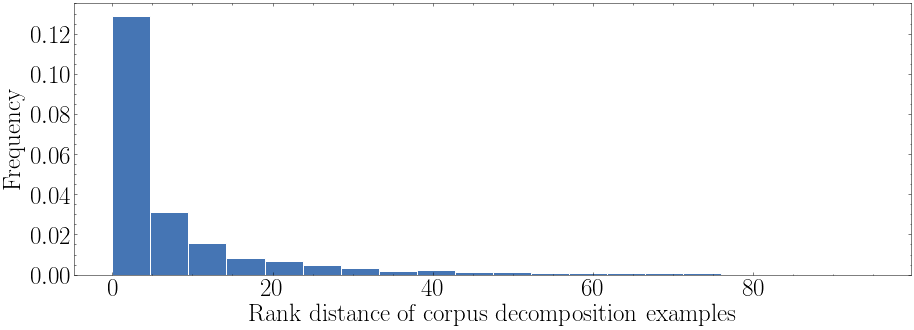

In [44]:
label_size = 35
tick_size = 25

plt.figure(figsize=(15,5))
plt.hist(all_ranks_full, bins=20, facecolor = '#4575b4', edgecolor='white',
         linewidth=1, density=True)
plt.ylabel('Frequency', fontsize=tick_size)
plt.xticks(fontsize = tick_size)
plt.yticks(fontsize = tick_size)
plt.xlabel('Rank distance of corpus decomposition examples', fontsize=tick_size)
plt.savefig('hist.pdf', format='pdf', dpi=1200)
plt.show()